# sanity checks on `models.NMF`

In [1]:
import numpy as np 
from provabgs import infer as Infer
from provabgs import models as Models
from astropy.cosmology import Planck13

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# load NMF model
Lets test NMF with and without bursts 

In [3]:
m_nmf_burst = Models.NMF(burst=True, emulator=False)

In [4]:
zred = 0.01
tage = Planck13.age(zred).value

In [5]:
prior = Infer.load_priors([
    Infer.UniformPrior(0., 0.), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1.), # fburst
    Infer.UniformPrior(0., tage), # tburst 
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

# sanity check SFH 

In [6]:
np.random.seed(0)

In [7]:
_theta = prior.sample()
theta = prior.transform(_theta)
print(theta)
print('fburst = %.2f' % theta[5])
print('tburst = %.2f' % theta[6])

# turn off burst
theta_wo_burst = theta.copy()
theta_wo_burst[5] = 0.

[ 0.00000000e+00  9.30036052e-01  5.23827603e-02  1.40866475e-03
  1.61725227e-02  8.14532409e-01  1.22635020e+01  2.66915048e-03
  5.68542312e-03  2.90301560e+00  4.65825296e-01 -1.07691497e+00]
fburst = 0.81
tburst = 12.26


In [8]:
t1, sfh1 = m_nmf_burst.SFH(theta_wo_burst, zred=zred)
t2, sfh2 = m_nmf_burst.SFH(theta, zred=zred)

(0.0, 13.653058838303744)

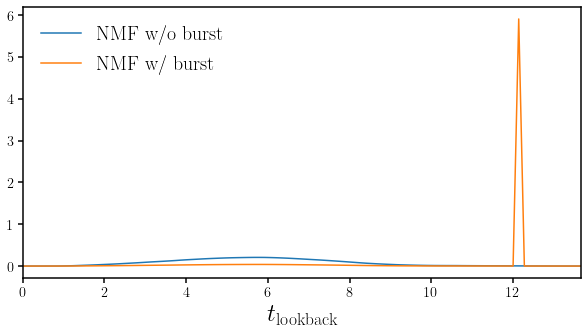

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(t1, sfh1, label=r'NMF w/o burst')
sub.plot(t2, sfh2, label=r'NMF w/ burst')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., tage)

# check SFH normalization

In [10]:
for i in range(100): 
    _theta = prior.sample()
    theta = prior.transform(_theta)
    
    theta_wo_burst = theta.copy()
    theta_wo_burst[5] = 0.
    
    t1, sfh1 = m_nmf_burst.SFH(theta_wo_burst, zred=zred)
    t2, sfh2 = m_nmf_burst.SFH(theta, zred=zred) 
    assert np.abs(np.trapz(sfh1, t1) - 1) < 1e-4, ('int(SFH) = %f' % np.trapz(sfh1, t1))
    assert np.abs(np.trapz(sfh2, t2) - 1) < 1e-4, ('int(SFH) = %f' % np.trapz(sfh2, t2))

# check average SFR calculation 

In [11]:
thetas = np.array([prior.transform(prior.sample()) for i in range(50000)])
thetas_wo_burst = thetas.copy()
thetas_wo_burst[:,5] = 0.

avgsfr1 = m_nmf_burst.avgSFR(thetas_wo_burst, zred, dt=0.1)
avgsfr2 = m_nmf_burst.avgSFR(thetas, zred, dt=0.1)

(-13.0, -7.0)

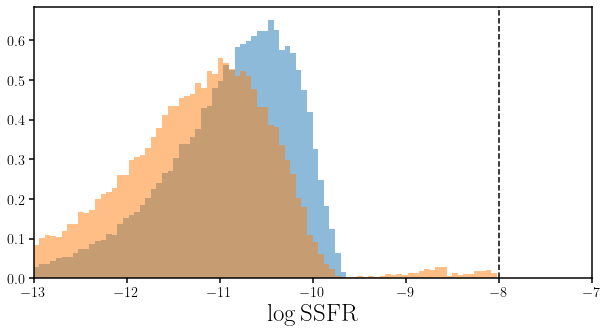

In [12]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.hist(np.log10(avgsfr1), range=(-13, -7), bins=100, alpha=0.5, density=True)
sub.hist(np.log10(avgsfr2), range=(-13, -7), bins=100, alpha=0.5, density=True)
sub.axvline(-8, color='k', linestyle='--')
sub.set_xlabel(r'$\log{\rm SSFR}$', fontsize=25)
sub.set_xlim(-13., -7.)

In [13]:
avgsfr1 = m_nmf_burst.avgSFR(thetas_wo_burst, zred, dt=1)
avgsfr2 = m_nmf_burst.avgSFR(thetas, zred, dt=1)

(-13.0, -7.0)

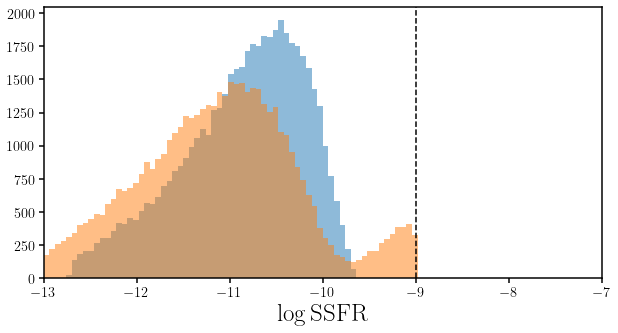

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.hist(np.log10(avgsfr1), range=(-13, -7), bins=100, alpha=0.5)
sub.hist(np.log10(avgsfr2), range=(-13, -7), bins=100, alpha=0.5)
sub.axvline(-9, color='k', linestyle='--')
sub.set_xlabel(r'$\log{\rm SSFR}$', fontsize=25)
sub.set_xlim(-13., -7.)

In [15]:
w1, f1 = m_nmf_burst.sed(theta_wo_burst, zred)
w2, f2 = m_nmf_burst.sed(theta, zred)

/Users/chahah/projects/provabgs/src/provabgs/models.py:667: RuntimeWarning: invalid value encountered in log10
  self._ssp.params['logzsol'] = np.log10(zh[i]/0.0190) # log(Z/Zsun)


(3000.0, 10000.0)

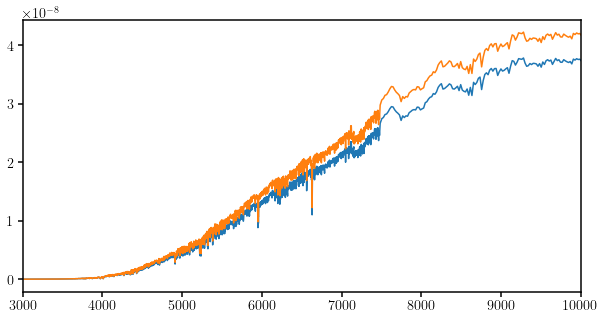

In [16]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(w1, f1)
sub.plot(w2, f2)
sub.set_xlim(3e3, 1e4)

In [17]:
# load test parameter and spectrum. These were generated for the validation of the trained Speculator model
test_w = np.load('/Users/chahah/data/provabgs/wave_fsps.npy')

test_theta0 = np.load('/Users/chahah/data/provabgs/fsps.nmf_bases.theta.test.npy')[:100]
test_logspec0 = np.load('/Users/chahah/data/provabgs/fsps.nmf_bases.lnspectrum.test.npy')[:100]

In [18]:
test_theta1 = np.load('/Users/chahah/data/provabgs/fsps.burst.theta.seed101.npy')[::10]
test_logspec1 = np.load('/Users/chahah/data/provabgs/fsps.burst.lnspectrum.seed101.npy')[::10]

In [19]:
igal = 27

_tt = np.zeros(test_theta1.shape[1])
_tt[1:5] = test_theta0[igal][:4]
_tt[7:] = test_theta0[igal][-6:-1]
w_test0, f_test0 = m_nmf_burst._sps_model(_tt, m_nmf_burst.cosmo.age(test_theta0[igal][-1]).value)

In [20]:
w_test1, f_test1 = m_nmf_burst._fsps_burst(test_theta1[igal])

(3000.0, 10000.0)

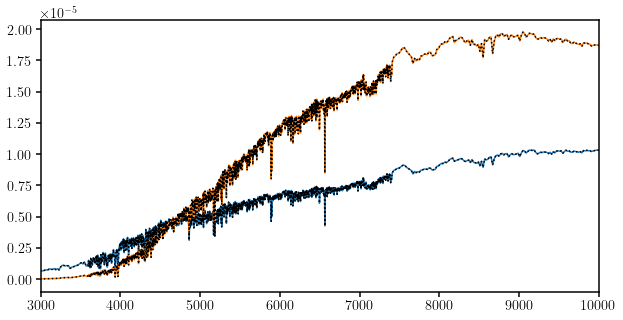

In [21]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(w_test0, f_test0)
sub.plot(test_w, np.exp(test_logspec0[igal]), c='k', ls=':')

sub.plot(w_test1, f_test1)
sub.plot(test_w, np.exp(test_logspec1[igal]), c='k', ls=':')
sub.set_xlim(3e3, 1e4)

In [22]:
for igal in np.random.choice(range(100), replace=False, size=10): 
    print(igal)
    _tt = np.zeros(test_theta1.shape[1])
    _tt[1:5] = test_theta0[igal][:4]
    _tt[7:] = test_theta0[igal][-6:-1]
    w_test0, f_test0 = m_nmf_burst._sps_model(_tt, m_nmf_burst.cosmo.age(test_theta0[igal][-1]).value)

    w_test1, f_test1 = m_nmf_burst._fsps_burst(test_theta1[igal])

    assert np.all(np.isclose(np.log(f_test0)[(w_test0 > 2300.) & (w_test0 < 11030)], test_logspec0[igal]))
    assert np.all(np.isclose(np.log(f_test1)[(w_test1 > 2300.) & (w_test1 < 11030)], test_logspec1[igal]))

26
86
2
55
75
93


/Users/chahah/projects/provabgs/src/provabgs/models.py:727: RuntimeWarning: invalid value encountered in log10
  self._ssp.params['logzsol'] = np.log10(zburst/0.0190) # log(Z/Zsun)


16
73
54
95
